In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product

In [85]:
df = pd.read_csv("/Users/chris/projects/Nature2023MooneyScripts/results/learning_comparison.csv")

In [86]:
df.head()

,Source,Detailed source,Subject,Image index,Phase,Correct,Predicted,Ground truth class
0,Human,Human-0,0,0,pre,1,???,dog
1,Human,Human-0,0,0,gray,1,???,dog
2,Human,Human-0,0,0,post,1,???,dog
3,Human,Human-1,1,0,pre,0,???,dog
4,Human,Human-1,1,0,gray,1,???,dog


In [87]:
df = df[df["Source"] != "Model"]

## Special: Remove models, and load the cornet models

In [88]:
blt_other_df_path = "/Users/chris/projects/Nature2023MooneyScripts/results/model_behaviors_BLT.csv"
blt_other_df = pd.read_csv(blt_other_df_path)

# Grab the Ground truth class from df
image_index_to_gt_class = dict(zip(df["Image index"], df["Ground truth class"]))
blt_other_df["Ground truth class"] = blt_other_df["Image index"].map(image_index_to_gt_class)

In [89]:
blt_other_df["Source"] = "BLT"
blt_other_df["Detailed source"] = blt_other_df["Subject"].apply(lambda x: f"BLT-1-{x}")
blt_other_df["Correct"] = "???"
blt_other_df.head()

,Subject,Image index,Predicted,Phase,Ground truth class,Source,Detailed source,Correct
0,0,2,"disk brake, disc brake",pre,ox,BLT,BLT-1-0,???
1,0,1,toy terrier,pre,dog,BLT,BLT-1-0,???
2,0,3,EntleBucher,pre,moped,BLT,BLT-1-0,???
3,0,3,boxer,gray,moped,BLT,BLT-1-0,???
4,0,2,"pug, pug-dog",gray,ox,BLT,BLT-1-0,???


In [90]:
other_df_path = "/Users/chris/projects/Nature2023MooneyScripts/results/model_behaviors_cornet.csv"
other_df = pd.read_csv(other_df_path)

# Grab the Ground truth class from df
image_index_to_gt_class = dict(zip(df["Image index"], df["Ground truth class"]))
other_df["Ground truth class"] = other_df["Image index"].map(image_index_to_gt_class)

In [91]:
other_df["Source"] = "CORNET"
other_df["Detailed source"] = other_df["Subject"].apply(lambda x: f"CORNET-1-{x}")
other_df["Correct"] = "???"
other_df.head()

,Subject,Image index,Predicted,Phase,Ground truth class,Source,Detailed source,Correct
0,0,2,"chocolate sauce, chocolate syrup",pre,ox,CORNET,CORNET-1-0,???
1,0,1,daisy,pre,dog,CORNET,CORNET-1-0,???
2,0,3,gyromitra,pre,moped,CORNET,CORNET-1-0,???
3,0,3,English foxhound,gray,moped,CORNET,CORNET-1-0,???
4,0,2,"Norwegian elkhound, elkhound",gray,ox,CORNET,CORNET-1-0,???


In [92]:
df = pd.concat([df, blt_other_df, other_df]).reset_index(drop=True)
df.head()

,Source,Detailed source,Subject,Image index,Phase,Correct,Predicted,Ground truth class
0,Human,Human-0,0,0,pre,1,???,dog
1,Human,Human-0,0,0,gray,1,???,dog
2,Human,Human-0,0,0,post,1,???,dog
3,Human,Human-1,1,0,pre,0,???,dog
4,Human,Human-1,1,0,gray,1,???,dog


## Rank human performance

In [93]:
human_df = df[df["Source"] == "Human"]
n_images = len(human_df["Image index"].unique())
n_subjects = len(human_df["Subject"].unique())

corrects = np.full((n_subjects, n_images, 2), np.nan)
for (subject, phase, image_index), small_df in human_df.groupby(
    ["Subject", "Phase", "Image index"]
):
    if phase == "pre":
        corrects[subject, image_index, 0] = small_df["Correct"].astype(int).mean()
    else:
        corrects[subject, image_index, 1] = small_df["Correct"].astype(int).mean()

# Calculate 0, 1 pattern
vote = ((corrects[:, :, 0] == 0) & (corrects[:, :, 1] == 1)).sum(0)
vote

# Top 90 images
top_90_images = vote.argsort()[-90:][::-1]
top_90_images

array([ 75,   3, 140, 134, 121, 158,  76, 174, 142,  87, 120, 118,  96,
        90,  60,  13, 126, 123, 175, 102,  79, 170,   4,   2, 107,  78,
       150, 144, 212,   7,  81, 136, 135,  15, 114, 199, 160,  26, 122,
       200,  20,  29,  74, 117, 155, 154, 115, 151, 100,  98,  77, 105,
        99, 143,  80, 130, 116,  83, 109, 108,  10,  27,  21,  37,  19,
       203,  47,  17, 166,  64,  56,  55,  12,  23,  89,  93,  25,  94,
         5, 193, 196,   8, 197, 186, 205,  88,  73,  69,  33, 156])

In [94]:
# Only keep these 90
df = df[df["Image index"].isin(top_90_images)]

## Find which classes the model couldn't possibly get

In [95]:
to_parse = df[df["Source"] != "Human"]

In [96]:
target_class = df["Ground truth class"]

In [97]:
pred_class = df["Predicted"]

In [98]:
import json

# Load the mapping
mapping = json.load(open("../../data/imagenet_label_to_wordnet_synset.json"))
behavior_mapping = json.load(open("../../data/wordnet_translation.json"))

In [99]:
from nltk.corpus import wordnet as wn

In [100]:
mapper_imagenet_name_2_wn_synset = {}

unknown_class = []
all_target_classes = set(target_class)
for c in all_target_classes:
    has_match = False
    for imagenet_class_d in mapping.values():

        # Get the synset of imagenet class
        synset = wn.synset_from_pos_and_offset("n", int(imagenet_class_d["id"].split("-")[0]))

        if imagenet_class_d["label"] not in mapper_imagenet_name_2_wn_synset:
            mapper_imagenet_name_2_wn_synset[imagenet_class_d["label"]] = synset

        # Get the synset of the target class
        target_synset = wn.synset(behavior_mapping[c])

        # If has a match
        if target_synset in synset.lowest_common_hypernyms(target_synset):
            has_match = True

    if not has_match:
        unknown_class.append(c)

# ImageNet doesn't have person
unknown_class.append("person")

In [101]:
# This is not terribly accurate. Remove unknown_classes that are known to be predicted
final_unknown_class = []
for c in unknown_class:
    if c not in df["Predicted"].unique():
        final_unknown_class.append(c)

In [102]:
final_unknown_class.remove("barrel")

In [103]:
final_unknown_class

['anchor', 'chandelier', 'helicopter', 'bonsai', 'statue', 'person']

In [104]:
check_dropped_df = df.groupby("Image index").agg({"Ground truth class": "first"}).reset_index()
len(check_dropped_df[check_dropped_df["Ground truth class"].isin(final_unknown_class)])

12

## Convert the classes to model's

In [105]:
other_pairs = [
    ("tusker", "elephant"),
    ("scooter", "moped"),
    ("trolley", "trolley"),
    ("trimaran", "boat"),
    ("catamaran", "boat"),
    ("palace", "castle"),
]

# Mark removal of unknown classes
df["to_remove"] = False
for idx, row in df.iterrows():

    if row["Ground truth class"] in final_unknown_class:
        df.loc[idx, "to_remove"] = True
        continue

    if row["Correct"] in ["0", "1"]:
        df.loc[idx, "Correct"] = int(row["Correct"])

    match = False
    for pair in other_pairs:
        if pair[0] in row["Predicted"] and pair[1] in row["Ground truth class"]:
            df.loc[idx, "Correct"] = 1
            match = True
            break

    if match:
        continue

    if row["Source"] in ["BLT", "CORNET"]:
        target_name = row["Ground truth class"]
        pred_name = row["Predicted"]

        # This should be ignored
        if pred_name == "crane2":
            pred_name = "crane"

        if target_name == pred_name:
            df.loc[idx, "Correct"] = 1

        else:
            # If the lowest common hypernym is the ground truth or the prediction, count as correct
            imagenet_class_synset = mapper_imagenet_name_2_wn_synset[pred_name]

            # Get the groundtruth synset
            gt_synset = wn.synset(behavior_mapping[target_name])

            # Get the LCH
            lch = imagenet_class_synset.lowest_common_hypernyms(gt_synset)
            if any([lch_synset == gt_synset for lch_synset in lch]):
                df.loc[idx, "Correct"] = 1
            elif any([lch_synset == imagenet_class_synset for lch_synset in lch]):
                df.loc[idx, "Correct"] = 1
            else:
                df.loc[idx, "Correct"] = 0

In [106]:
df_new = df[~df["to_remove"]]
df_new

,Source,Detailed source,Subject,Image index,Phase,Correct,Predicted,Ground truth class,to_remove
72,Human,Human-0,0,2,pre,0,???,ox,False
73,Human,Human-0,0,2,gray,1,???,ox,False
74,Human,Human-0,0,2,post,0,???,ox,False
75,Human,Human-1,1,2,pre,0,???,ox,False
76,Human,Human-1,1,2,gray,1,???,ox,False
...,...,...,...,...,...,...,...,...,...
23601,CORNET,CORNET-1-11,11,203,gray,0,bee,chair,False
23604,CORNET,CORNET-1-11,11,205,pre,0,table lamp,elephant,False
23607,CORNET,CORNET-1-11,11,203,post,0,"dragonfly, darning needle, devil's darning nee...",chair,False
23610,CORNET,CORNET-1-11,11,205,gray,0,"dragonfly, darning needle, devil's darning nee...",elephant,False


In [107]:
df_new.drop(columns=["to_remove"], inplace=True)

/var/folders/js/6gw33t_51rqcvbmgmlr5ybtw0000gn/T/ipykernel_87988/191651671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop(columns=["to_remove"], inplace=True)


In [108]:
df = df_new.drop(columns=["Ground truth class", "Predicted"])
df["Correct"] = df["Correct"].astype(int)
df.head()

,Source,Detailed source,Subject,Image index,Phase,Correct
72,Human,Human-0,0,2,pre,0
73,Human,Human-0,0,2,gray,1
74,Human,Human-0,0,2,post,0
75,Human,Human-1,1,2,pre,0
76,Human,Human-1,1,2,gray,1


In [24]:
df.to_clipboard()

## Performance comparison

In [109]:
# Aggregate by subject and source
agg_df = df.drop(columns=["Image index"])
agg_df = agg_df.groupby(["Subject", "Source", "Phase"]).mean(numeric_only=True).reset_index()
agg_df.head(6)

,Subject,Source,Phase,Correct
0,0,BLT,gray,0.012821
1,0,BLT,post,0.012821
2,0,BLT,pre,0.038462
3,0,CORNET,gray,0.038462
4,0,CORNET,post,0.000000
5,0,CORNET,pre,0.000000


In [26]:
agg_df.to_clipboard()

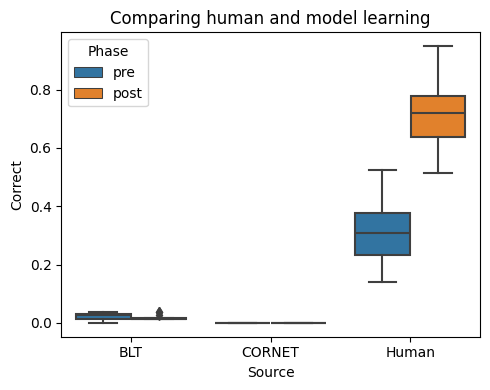

In [113]:
plt.figure(figsize=(5, 4))
sns.boxplot(data=agg_df, x="Source", y="Correct", hue="Phase", hue_order=["pre", "post"])

# Turn off boundary
plt.title("Comparing human and model learning")
plt.tight_layout()

Text(0.5, 0, 'Learner')

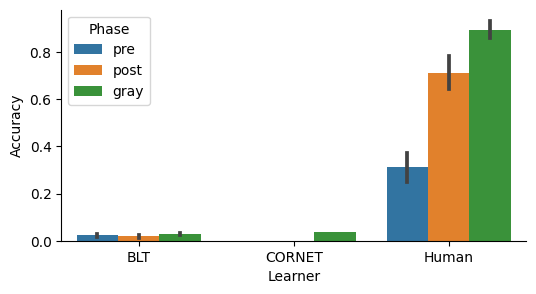

In [119]:
plt.figure(figsize=(6, 3))
sns.barplot(data=agg_df, x="Source", y="Correct", hue="Phase", hue_order=["pre", "post", "gray"])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.ylabel("Accuracy")
plt.xlabel("Learner")

In [31]:
agg_df.groupby(["Source", "Phase"]).agg({"Correct": "median"}).reset_index()

,Source,Phase,Correct
0,Human,gray,0.876623
1,Human,post,0.714286
2,Human,pre,0.305195
3,Model,gray,0.038961
4,Model,post,0.000000
5,Model,pre,0.000000
